In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pbdlib as pbd

%matplotlib inline
%load_ext autoreload
%autoreload 2

from pbdlib.utils.jupyter_utils import *
np.set_printoptions(precision=2)

## Gaussian Mixture Model (GMM)

Analysis of the basics notebook


Now to check with data created from demonstrations

In [2]:
dp = os.path.dirname(pbd.__file__) + '/data/demos/corrected'
filelist = next(os.walk(dp))[2]
filelist_short = filelist[0:5]
data = []
for f in filelist_short:
    temp = np.genfromtxt(dp + '/' + f, delimiter=',')
    data.append(temp)

In [3]:
print(filelist_short)

['trial_024_slash_relaxed_ik_slash_ee_pose_goals.csv', 'trial_113_slash_relaxed_ik_slash_ee_pose_goals.csv', 'trial_085_slash_relaxed_ik_slash_ee_pose_goals.csv', 'trial_142_slash_relaxed_ik_slash_ee_pose_goals.csv', 'trial_016_slash_relaxed_ik_slash_ee_pose_goals.csv']


In [4]:
t = np.linspace(0, 100, data[0].shape[0])

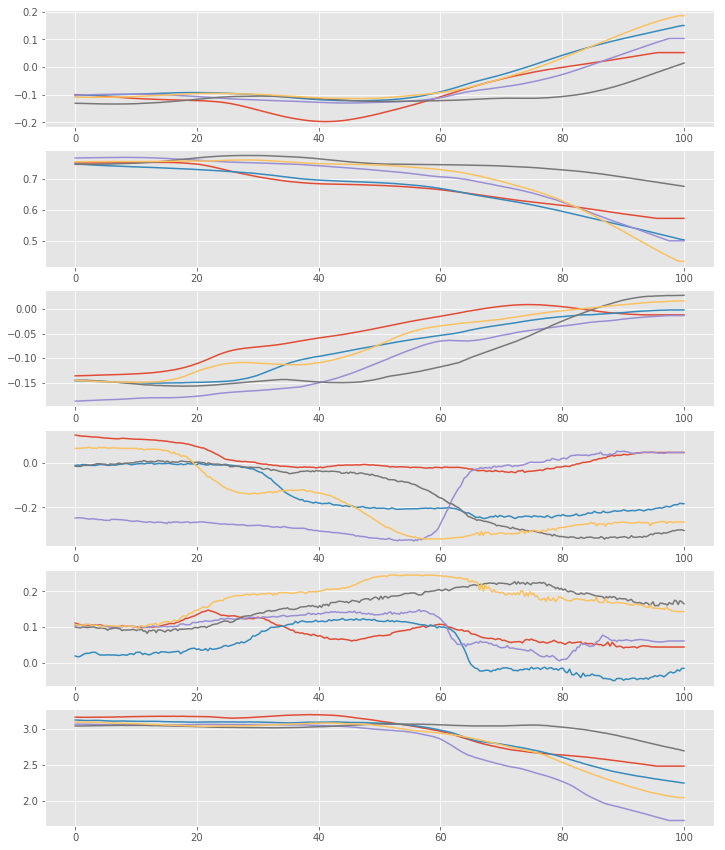

In [5]:
# plotting
fig, ax = plt.subplots(nrows=6)
fig.set_size_inches(12,15)
for i in range(6):
    for p in data:
        ax[i].plot(t, p[:, i])

In [6]:
# Fix for start and end frame
data_start = []
data_end = []
def transform_matrix_3D(a):
    # Translation
    dX = - equal[0]
    dY = - equal[1]
    dZ = - equal[2]

    # Rotation
    rC = np.cos(equal[3])
    rS = np.sin(equal[3])
    pC = np.cos(equal[4])
    pS = np.sin(equal[4])
    yC = np.cos(equal[5])
    yS = np.sin(equal[5])

    #Matrices and dot product
    Translate_matrix = np.array([[1, 0, 0, dX],
                               [0, 1, 0, dY],
                               [0, 0, 1, dZ],
                               [0, 0, 0, 1]])
    Rotate_X_matrix = np.array([[1, 0, 0, 0],
                              [0, rC, -rS, 0],
                              [0, rS, rC, 0],
                              [0, 0, 0, 1]])
    Rotate_Y_matrix = np.array([[pC, 0, pS, 0],
                              [0, 1, 0, 0],
                              [-pS, 0, pC, 0],
                              [0, 0, 0, 1]])
    Rotate_Z_matrix = np.array([[yC, -yS, 0, 0],
                              [yS, yC, 0, 0],
                              [0, 0, 1, 0],
                              [0, 0, 0, 1]])
    rot_3d_matrix = np.dot(Rotate_Z_matrix,np.dot(Rotate_Y_matrix,np.dot(Rotate_X_matrix,Translate_matrix)))

    # Apply translation and rotation
    pos = [a[0], a[1], a[2], 1]
    pos_trans = np.dot(rot_3d_matrix,np.transpose(pos))[0:3]
    ori_trans = a[3:] - equal[3:]
    pose_trans = np.concatenate((pos_trans, ori_trans), axis=None)

    return pose_trans

for p in data:
    # Set start point
    equal = p[0,:]
    arr_trans = np.apply_along_axis(transform_matrix_3D, 1, p)
    data_start.append(arr_trans)

for p in data:
    # Set start point
    equal = p[-1,:]
    arr_trans = np.apply_along_axis(transform_matrix_3D, 1, p)
    data_end.append(arr_trans)

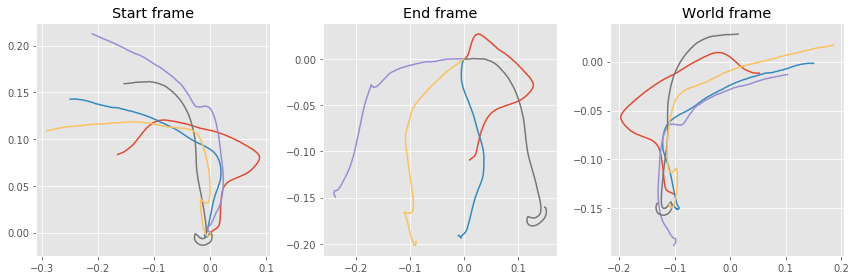

In [7]:
fig, ax = plt.subplots(ncols=3)
fig.set_size_inches(12,4)
# Set corresponding axis for plot
x = 0
y = 2

ax[0].set_title('Start frame')
for p in data_start:
    ax[0].plot(p[:, x], p[:, y])
    
ax[1].set_title('End frame')
for p in data_end:
    ax[1].plot(p[:, x], p[:, y])
    
ax[2].set_title('World frame')
for p in data:
    ax[2].plot(p[:, x], p[:, y])
plt.tight_layout()

This cell runs the GMM with the start and end frame

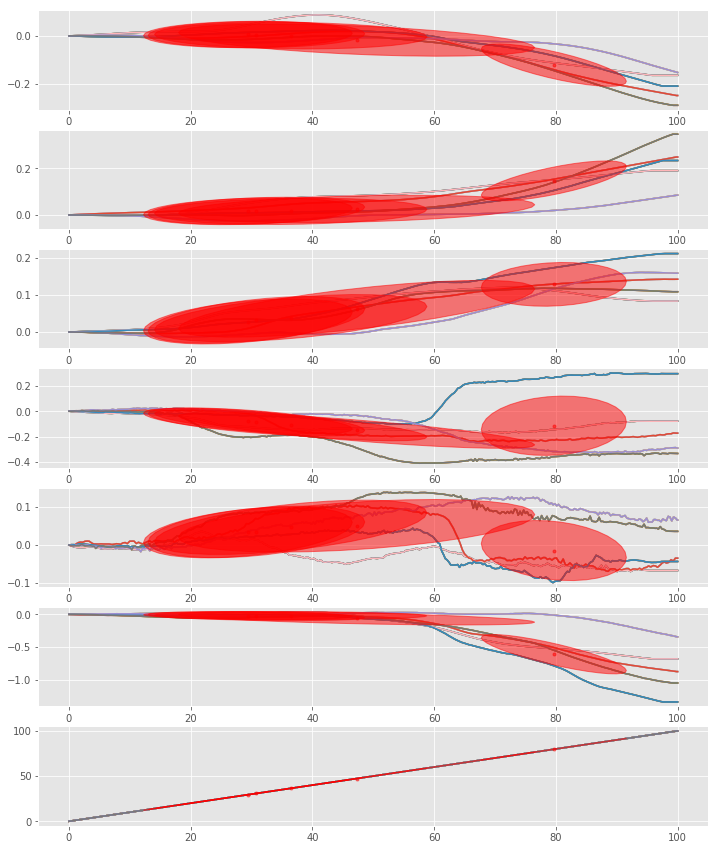

In [9]:
demos = [np.hstack([t[:,None], s, t[:,None], e]) for e in data_end for s in data_start]
data2 = np.vstack([d for d in demos])

model = pbd.GMM(nb_dim=8, nb_states=5)

model.init_hmm_kbins(demos)

model.em(data2, reg=[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])
   
# plotting
fig, ax = plt.subplots(nrows=7)
fig.set_size_inches(12,15)

# position plotting

for i in range(7):

    for p in demos:
        ax[i].plot(p[:, 0], p[:, i + 1])

    pbd.plot_gmm(model.mu, model.sigma, ax=ax[i], dim=[0, i + 1]);

This cell runs the GMR from the end frame

In [10]:
mu, sigma = model.condition(t[:, None], dim_in=slice(0, 1), dim_out=slice(4, 8))

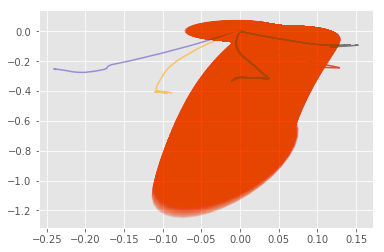

In [11]:
pbd.plot_gmm(mu, sigma, dim=[1, 2], color='orangered', alpha=0.01)

for d in data_end:
    plt.plot(d[:, 0], d[:, 1])
#plt.plot(mu[:,1], mu[:,2])

Now to combine Gaussians and perform GMR

In [12]:
nbcol = 3
fig, ax = plt.subplots(ncols=nbcol, nrows=np.ceil(float(len(data_1))/nbcol).astype(np.int))
fig.set_size_inches(14, 3 * ax.shape[0])
ax = ax.reshape(-1)

for i in range(len(data_1)):
    yaw0 = data_1[i][0,2]
    A0 = np.array([[1,0,0,0],[0, np.cos(yaw0),-np.sin(yaw0),0],[0, np.sin(yaw0),np.cos(yaw0),0],[0,0,0,1]])
    b0 = [0, data_1[1][0,0], data_1[1][0,1], data_1[1][0,2]]
    
    yawn = data_1[i][-1,2]
    An = np.array([[1,0,0,0],[0, np.cos(yawn),-np.sin(yawn),0],[0, np.sin(yawn),np.cos(yawn),0],[0,0,0,1]])
    bn = [0, data_1[1][-1,0], data_1[1][-1,1], data_1[1][-1,2]]
    
    _mod1 = model.marginal_model(slice(0, 4)).lintrans(A0, b0)
    _mod2 = model.marginal_model(slice(4, 8)).lintrans(An, bn)
    
    # product 
    _prod = _mod1 * _mod2
    
    # get the most probable trajectory for this demonstration
    _mu, _sigma = _prod.condition(t[:, None], dim_in=slice(0, 1), dim_out=slice(0, 4))
        
    pbd.plot_gmm(_mod1.mu, _mod1.sigma, swap=True, ax=ax[i], dim=[1, 2], color='steelblue', alpha=0.3)
    pbd.plot_gmm(_mod2.mu, _mod2.sigma, swap=True, ax=ax[i], dim=[1, 2], color='orangered', alpha=0.3)
    
    pbd.plot_gmm(_prod.mu, _prod.sigma, swap=True, ax=ax[i], dim=[1, 2], color='gold', alpha=0.3)
    #pbd.plot_gmm(_mu, _sigma, alpha=0.01, ax=ax[i], dim=[1, 2], color='gold')
    ax[i].plot(_mu[:,1], _mu[:,2], color='red')
    
    ax[i].plot(data_1[i][:, 0], data_1[i][:, 1], 'k--', lw=2)

plt.tight_layout()

NameError: name 'data_1' is not defined

In [ ]:
i = 0
yaw0 = data_1[i][0,2]
A0 = np.array([[1,0,0,0],[0, np.cos(yaw0),-np.sin(yaw0),0],[0, np.sin(yaw0),np.cos(yaw0),0],[0,0,0,1]])
b0 = [0, data_1[1][0,0], data_1[1][0,1], data_1[1][0,2]]

yawn = data_1[i][-1,2]
An = np.array([[1,0,0,0],[0, np.cos(yawn),-np.sin(yawn),0],[0, np.sin(yawn),np.cos(yawn),0],[0,0,0,1]])
bn = [0, data_1[1][-1,0], data_1[1][-1,1], data_1[1][-1,2]]

_mod1 = model.marginal_model(slice(0, 4)).lintrans(A0, b0)
_mod2 = model.marginal_model(slice(4, 8)).lintrans(An, bn)

# product 
_prod = _mod1 * _mod2

In [ ]:
pbd.plot_gmm(_mod2.mu, _mod2.sigma, dim=[1, 2], color='steelblue')

for d in data_1:
    plt.plot(d[:, 0], d[:, 1])

In [ ]:
pbd.plot_gmm(_mod1.mu, _mod1.sigma, dim=[2, 3], color='orangered')

for d in data_1:
    plt.plot(d[:, 1], d[:, 2])